In [11]:
import pandas as pd
import glob
import os

In [2]:
data_pattern = os.path.join("..", "..", "data", "csv", 
                            "431c482884426fa35f0e910e3b7ea769a1672c97", 
                            "*", "*.csv")
                            
# Get list of all CSV file paths that match the pattern.
csv_files = glob.glob(data_pattern)

print(f"Found {len(csv_files)} CSV files.")

Found 72 CSV files.


In [3]:
# Initialize an empty list to store individual DataFrames.
df_list = []

# Loop through each file, read it, and optionally add a column to record its source date.
for file in csv_files:
    # Read the CSV file into a DataFrame.
    df = pd.read_csv(file)
    
    # Optionally, extract the date folder from the file path.
    # For example, if file is '.../2024-11/2024-11-city-of-london-street.csv'
    # then parts[-2] should be '2024-11'
    # parts = file.split(os.sep)
    # date_folder = parts[-2]
    # df['date'] = date_folder  # Add a new column indicating the folder/date
    
    # Optionally, you can also add a column indicating which type of CSV this is,
    # for example, checking if "metropolitan" is in the filename.
    # if "metropolitan" in os.path.basename(file).lower():
    #     df['file_type'] = "metropolitan-street"
    # elif "city-of-london" in os.path.basename(file).lower():
    #     df['file_type'] = "city-of-london-street"
    # else:
    #     df['file_type'] = "unknown"
    
    # Append the DataFrame to the list.
    df_list.append(df)


In [4]:
combined_df = pd.concat(df_list, ignore_index=True)

# Check the result
print("Combined DataFrame shape:", combined_df.shape)
combined_df.head()

Combined DataFrame shape: (3399985, 12)


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,b74d06161e2425ef2abf28345aa962fa862753669659d3...,2024-09,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Robbery,Unable to prosecute suspect,NaN
1,ab9f963604d03486ffbefec80f9f9296c7f65ecd4cd047...,2024-09,City of London Police,City of London Police,-0.107682,51.517786,On or near B521,E01000917,Camden 027C,Violence and sexual offences,Unable to prosecute suspect,NaN
2,71c1e6edfb73383e82ca6acdc1c9c0ef015334b529f298...,2024-09,City of London Police,City of London Police,-0.111596,51.518281,On or near Chancery Lane,E01000914,Camden 028B,Violence and sexual offences,Under investigation,NaN
3,7eaad3255f757cf5073dfd3712193f4497e788b3f6519f...,2024-09,City of London Police,City of London Police,-0.112096,51.515942,On or near Nightclub,E01000914,Camden 028B,Violence and sexual offences,Under investigation,NaN
4,bb39d159456b57653bae7b4613cbe7cff560e980fa3a59...,2024-09,City of London Police,City of London Police,-0.097245,51.515387,On or near St Martin'S Le Grand,E01000001,City of London 001A,Other theft,Investigation complete; no suspect identified,NaN


In [16]:
# Define the list of columns you want to drop
columns_to_drop = [
    "Crime ID", 
    "Reported by", 
    "Falls within", 
    "LSOA code", 
    "LSOA name", 
    "Last outcome category",
    "Context"
]

# Drop the columns. Setting errors='ignore' prevents errors if any column is missing.
combined_df = combined_df.drop(columns=columns_to_drop, errors='ignore')

# Check the resulting DataFrame's columns
combined_df.head()
# print("Combined DataFrame shape:", combined_df.shape)



,Month,Longitude,Latitude,Location,Crime type
0,2024-09,-0.107682,51.517786,On or near B521,Robbery
1,2024-09,-0.107682,51.517786,On or near B521,Violence and sexual offences
2,2024-09,-0.111596,51.518281,On or near Chancery Lane,Violence and sexual offences
3,2024-09,-0.112096,51.515942,On or near Nightclub,Violence and sexual offences
4,2024-09,-0.097245,51.515387,On or near St Martin'S Le Grand,Other theft


In [17]:
unique_crime_types = combined_df["Crime type"].unique()
print(unique_crime_types)


['Robbery' 'Violence and sexual offences' 'Other theft' 'Shoplifting'
 'Theft from the person' 'Bicycle theft' 'Drugs'
 'Criminal damage and arson' 'Vehicle crime' 'Anti-social behaviour'
 'Burglary' 'Public order' 'Other crime' 'Possession of weapons']


In [5]:
!pip install shapely

Defaulting to user installation because normal site-packages is not writeable
  Using cached shapely-2.0.7-cp312-cp312-win_amd64.whl.metadata (7.1 kB)
Using cached shapely-2.0.7-cp312-cp312-win_amd64.whl (1.4 MB)


In [9]:
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import unary_union

route_segments = [
    ((-0.1278, 51.5074), (-0.1300, 51.5080)),
    ((-0.1300, 51.5080), (-0.1320, 51.5090))
]

# 51.501130, -0.211974


# Create a list of LineStrings from the route segments
lines = [LineString(segment) for segment in route_segments]

# Optionally, merge the segments into a single geometry (if the segments are contiguous)
route_geometry = unary_union(lines)

# Create a buffer around the route (in degrees, or better convert to a projected coordinate system)
buffer_distance = 0.001  # roughly ~10m depending on location; adjust as needed
route_buffer = route_geometry.buffer(buffer_distance)

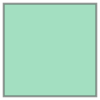

In [10]:
def square_bounds(polygon):
    """
    Returns a square Polygon that bounds the input polygon.

    Parameters:
        polygon (shapely.geometry.Polygon): The input polygon.

    Returns:
        shapely.geometry.Polygon: A square polygon that fully contains the input polygon.
    """
    # Get the original bounding box
    minx, miny, maxx, maxy = polygon.bounds
    width = maxx - minx
    height = maxy - miny
    
    # Determine the side length of the square (largest of width or height)
    side = max(width, height)
    
    # Calculate the center of the bounding box
    center_x = (minx + maxx) / 2.0
    center_y = (miny + maxy) / 2.0
    
    # Determine half the side length
    half_side = side / 2.0
    
    # Create square coordinates
    square_coords = [
        (center_x - half_side, center_y - half_side),
        (center_x + half_side, center_y - half_side),
        (center_x + half_side, center_y + half_side),
        (center_x - half_side, center_y + half_side),
        (center_x - half_side, center_y - half_side)  # Closing the polygon
    ]
    
    return Polygon(square_coords)

square_bounds(route_buffer)

In [23]:
def is_crime_on_route(row):
    crime_point = Point(row['Longitude'], row['Latitude'])
    return route_buffer.contains(crime_point)

# Filter the DataFrame
df_on_route = combined_df[combined_df.apply(is_crime_on_route, axis=1)]

print(df_on_route)

           Month  Longitude   Latitude  \
92770    2024-09  -0.128042  51.507394   
92775    2024-09  -0.128042  51.507394   
92792    2024-09  -0.128042  51.507394   
92795    2024-09  -0.128042  51.507394   
92833    2024-09  -0.130426  51.508286   
...          ...        ...        ...   
3396714  2023-07  -0.128042  51.507394   
3396778  2023-07  -0.128042  51.507394   
3396825  2023-07  -0.128042  51.507394   
3396903  2023-07  -0.128042  51.507394   
3396920  2023-07  -0.128042  51.507394   

                                               Location  \
92770                          On or near Charing Cross   
92775                          On or near Charing Cross   
92792                          On or near Charing Cross   
92795                          On or near Charing Cross   
92833    On or near Further/Higher Educational Building   
...                                                 ...   
3396714                        On or near Charing Cross   
3396778                